# Laboratory 1: Dynamics & Perception 
version 1.0 Feb 5 2021 (for eventual release to public) 

**Note:** You should complete the PsyNeuLink Beginner Tutorial prior to starting Lab 1, unless you are already familiar with the PsyNeuLink environment.  

## Lab 1 Overview
 
In this lab we will explore dynamic models using some examples from Perception.  We'll start with a Hopfield Network that takes noisy input and settles on a stable interpretation, then we'll explore some simple examples of dynamic networks evolving over time, and finally consider bistable percepts that can be interpretted multiple ways.  Along the way we'll cover numerous examples and concepts that recur and are useful throughout this course.     



 

In [2]:
!pip install psyneulink


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
# % matplotlib inline
import psyneulink as pnl

# This couple of lines sets our color palette
# import seaborn as sb
# sb.palplot(sb.color_palette("RdBu_r",7))
# sb.set_palette("RdBu_r")
# sb.set_style("whitegrid")

#matplotlib.colors.Colormap("RdBu_r")

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Noisy Input and Perception: Hopfield Networks

When you are looking out at the world through a rainstorm, your sense data are noisy with a messy distribution of water droplets partially obscuring your view at any given moment, but you are typically still able to recognize the landscape.  Similarly, if you are walking through a forest on a sunny windy day the pattern of sunlight dancing on the forest floor makes your raw sense data fluctuate unpredictably, but you can still reliably recognize the path, plants, stones, etc.  Sense data are often noisy, and Hopfield Networks can model how to reliably extract signal from and input of signal mixed with noise using associative nodes and thresholds.  


### Letter Recognition

A toy problem-to-be solved by a Hopfield Network is recognizing the letter A or letter Z.  In the next cell we'll set up the target patterns and then structure the network to encode correlations within patterns.  

 

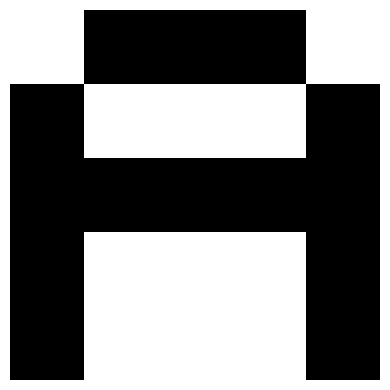

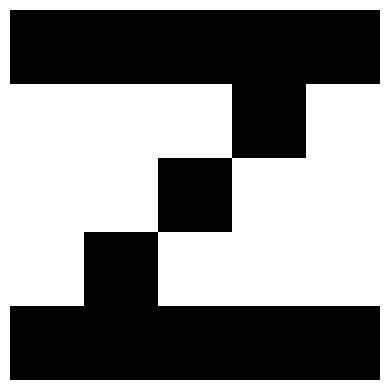

In [8]:
# make some patterns
side_len = 5
A = np.array([
    [-1,  1,  1,  1, -1],
    [ 1, -1, -1, -1,  1],
    [ 1,  1,  1,  1,  1],
    [ 1, -1, -1, -1,  1],
    [ 1, -1, -1, -1,  1],
]).reshape(-1)

Z = np.array([
    [ 1,  1,  1,  1,  1],
    [-1, -1, -1,  1, -1],
    [-1, -1,  1, -1, -1],
    [-1,  1, -1, -1, -1],
    [ 1,  1,  1,  1,  1],
]).reshape(-1)

def show_letter(pattern):
    f, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(pattern.reshape(side_len, side_len), cmap="bone_r")
    ax.set_axis_off()
    f.tight_layout()

# show the patterns
show_letter(A)
show_letter(Z)

### python functions
Next we will write some helpful functions in python to implement 

In [9]:
np.random.seed(0)
 
def pattern_complete(weights, X, n_iter=10, soft=False):
    Xs = [None] * n_iter
    for i in range(n_iter):
        X = np.dot(X, weights)
        if soft:
            X = np.tanh(X)
        else:
            X[X < 0] = -1
            X[X >= 0] = 1
        Xs[i] = X
    return Xs

def add_noise(x_, noise_level=.2):
    noise = np.random.choice(
        [1, -1], size=len(x_), p=[1-noise_level, noise_level])
    return x_ * noise

 


In [20]:
# memorize the patterns
X = np.array([A, Z])
m, n_units = np.shape(X)
weights = np.zeros((n_units, n_units))
for x in X:
    weights += np.outer(x, x) / m
weights[np.diag_indices(n_units)] = 0

# show the test pattern again
x_test = Z
show_letter(x_test)

# add noise
noise_level = .25
x_test = add_noise(x_test, noise_level=noise_level)
show_letter(x_test)

KeyboardInterrupt: 

In [19]:
# pattern completion
n_iter = 3
x_hats = pattern_complete(weights, x_test, n_iter=n_iter)
# show_letter(x_hats[-1])

f, axes = plt.subplots(1, n_iter+1, figsize=((n_iter+1)*3, 3))
x_hats.insert(0, x_test)
for i in range(n_iter+1):
    axes[i].imshow(x_hats[i].reshape(side_len, side_len), cmap='bone_r')
    axes[i].set_axis_off()
    axes[i].set_title(f'pattern completion, iter: {i}')
f.tight_layout()
# f.savefig('pc.png', dpi=100, bbox_inches='tight')

KeyboardInterrupt: 

 # Dynamic Systems & Bistable Perception

There are many different ways to configure and run a model.  From the previous examples you should have a sense of how to build different configurations for a model.  In the next section we are going to explore some **dynamics** of running a model, including how information flows and is modified over time.  We will be building up to a simple model of bistable perception for a figure that people can readily interpret in two different ways.    

![alt text](Lab1_duckrabbit_Necker.png "Bistable")

Two classic examples of bistable figures are the "Duck Rabbit" seen as either of two animals (but not usually both simultaneously), and the Necker Cube, where the face of the cube that you initially see as closest to you can alternatively be interpretted as farthest away from you.  We are going to work toward a Model of settling on one interpretation of the Necker Cube, after first exploring some simple dynamic models.

## Dynamics 1: Attractor State

The following code creates a composition with two mechanisms that are mutually connected by weights of -1. The output of one mechanism is multiplied by -1 and given as the input to the next mechanism, in a repeating cycle.  We can specify initial input values for each mechanism and watch it evolve over time.  

This particular mechanism will evolve toward stable values of 1 and -1.  The values 1 and -1 are determined by the difference between the initial inputs.  If the inputs are X and Y, this system will always evolve to +/-abs[X-Y]/4 (plus & minus the absolute value of the difference between the two inputs, divided by 4).  Whichever mechanism receives the larger initial input evolves to the positive value, while the smaller initial input evolves to the negative value.      

In [9]:
comp_attract = pnl.Composition()

node_attract1 = pnl.TransferMechanism(
    name='node_attract1',
    function=pnl.Linear(slope = 1, intercept = 0),
    integrator_mode = True,
    integration_rate = 0.5,
    default_variable=np.zeros((1,)),
)

# Integrator function ((1-smoothing_factor)*previous_value + smoothing_factor*current_input) * mechanism_function

node_attract2 = pnl.TransferMechanism(
    name='node_attract2',
    function=pnl.Linear(slope = 1, intercept = 0),
    integrator_mode = True,
    integration_rate = 0.5,
    default_variable=np.zeros((1,)),
)

connect_a1_a2 = ([-1])
connect_a2_a1 = ([-1])

weights_a1_a2 = pnl.MappingProjection(
    name='connect_a1_a2',
    matrix=connect_a1_a2,
)

weights_a2_a1 = pnl.MappingProjection(
    name='connect_a2_a1',
    matrix=connect_a2_a1,
)

#process1 = pnl.Process(pathway=[node1, weights_1_2, node2])
#process2 = pnl.Process(pathway=[node2, weights_2_1, node1])

#system1 = pnl.System(
#    processes=[process1, process2]
#)


comp_attract.add_linear_processing_pathway(pathway = (node_attract1, connect_a1_a2, node_attract2, connect_a2_a1, node_attract1))

node_attract1.reportOutputPref = True
node_attract2.reportOutputPref = True

input_a1 = 2
input_a2 = 6

input_dict = {node_attract1: [input_a1,0,0,0,0,0,0,0,0,0],
             node_attract2: [input_a2,0,0,0,0,0,0,0,0,0]
             }

#input_dict = {node1: [input1,1,1,1,1,1,1,1,1,1],
#             node2: [input2,1,1,1,1,1,1,1,1,1]
#             }

# input_dict = {node_attract1: [input_a1],
#             node_attract2: [input_a2]
#             }

comp_attract.run(input_dict, num_trials = 10)
comp_attract.show_graph()

We can plot the results over successive time steps to get a clearer sense of how the system evolves over time.  Compare the plot below to your understanding of how the system evolves.

(10, 2)
[[ 1.  3.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]]


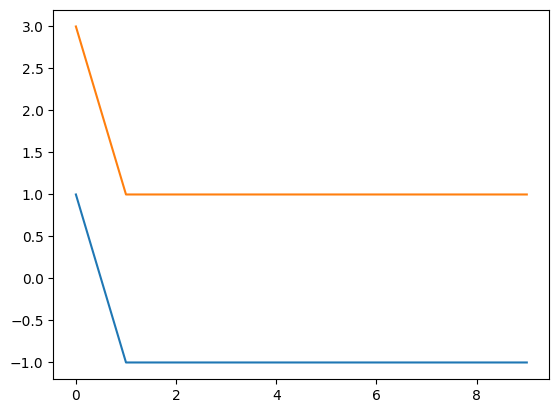

In [10]:
print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

In the previous cell, try changing the values of input1 and input2 and running the system again.  Look carefully at the code, and at the sequence of inputs and outputs when you run the system.  

We executed the system 10 times (num_trials = 10), with initial input values specified as input1 and input2, and all subsequent input values set equal to 0 in the input_dict.  What happens if you set all the subsequent input values to 1 instead of 0?  You can find out by uncommenting (remove #'s) the input_dict below the currently used input_dict (and comment out the previous version with 0s, by adding #'s at the start of those lines). 

What happens if you change the functions in the TransferMechanisms from Linear to Logistic (with default parameters, gain = 1, bias = 0, offset = 0)?  If you understand how the code is working, and how the logistic function works, then you should be able to explain the new pattern of output.  If you don't understand, ask a classmate or lab instructor.  


## Dynamics 2: Unstable Feedback Loops

While some systems evolve to fixed attractor states, others will evolve in a runaway cycle that goes continuously up or continuously down.  Still others behave chaotically.  If you give the previous system input values that are consistently different the outputs will continuously diverge.  For example if instead of both inputs being 0 or both being 1 (at each time step after the first one), the inputs are consistently different -- all 0s to node1 and all 1s to node2.  Try running the system with the following input:   

```python
input_dict = {node1: [2],
             node2: [0]
             }
```

(Note: if you only specify 1 input value for each node, the system will take this value as the input at every iterative execution.)

## Necker Cube Model

The Necker Cube is a 2D drawing with two common 3D interpretations: the faces of the cube that you see in the "front" and "back" can be reversed -- this also corresponds to seeing the 3D cube from "above" or "below."  With a little practice most people can alternate between seeing these two interpretations.  However, almost nobody looks at the figure and spontaneously sees a tangled 3D object with vertices at arbitrary depths, or a 3D "X" or any one of a vast number of other possibilities.  How you interpret the vertices seems to be a holistic (Gestalt) process where the local positions of vertices and 3D angles are fixed by a more global interpretation.  Could a network of merely local connections give rise to two distinct globally stable interpretations?  Put another way, could vertices represented with weights connecting only to a few local neighboring vertices spontaneously move toward either of two global attractor states corresponding to the two interpretations we actually see?  This question motivates the next models we will explore.  

How to model bistable interpretations of a Necker Cube is a classic example in cognitive modeling, and below are two figures from early textbooks.  

![figure](https://drive.google.com/uc?id=1gO790EP87DJ0sz96tY8_QAVxoLsBYLBg)
Figure Caption: Lab1_Feldman_NeckerFigure.png "Necker Figure 1"


You can get a sense from these two figures how we might label and organize a Necker cube model [Note: FUL stands for Front Upper Left, and the other abbreviations are similar.]  Take a few moments to infer as much as you can from the two figures. 

The following figure depicts how we will represent the vertices in our Necker Cube perception model.  Think of the red sides as the interpreted "front" of the cube.    

![figure](https://drive.google.com/uc?id=17t7ojMjC88WzYZlFDREPLY1G-63dLZuD)
Figure Caption: Lab1_NeckerCode.png "Necker Figure 3"



We'll use 16 nodes, numbered 0 to 15 [because Python indexes arrays starting with 0].  The figure shows that we want activations of these 16 nodes to cluster into two groups, 0-7 and 8-15, and we want these clusters to mutually inhibit each other so that only one cluster is active together at a time, corresponding to one interpretation of the Necker Cube at a time. 

Remember that we are aiming to create this emergent order of clustering and mutual inhibition out of only local connections.  In the following cell we will create a matrix specifying the connection weights.  Look down at the second line: Build_N_Matrix[0,:] = [0, 1, 3, 4, 8].  You can think of the numbers [0, 1, 3, 4, 8] like this: the first number [0] is a vertex (more specifically, it is a particular 3D interpretation of the spatial position of that vertex), the next three numbers [1, 3, 4] are vertex interpretations that will have excitatory connections to [0], and the last number [8] will have an inhibitory connection to [0].  Now look back at the figure above to fully understand this schematic.  In the left cube 0 is connected by an edge to three other vertices [1, 3, 4].  In the right cube, vertex 8 is in the same position as 0 but has the opposite depth interpretation: 0 and 8 are mutually exclusive interpretations, and their activations should be inversely related using mutual inhibition.        

In [ ]:
Build_N_Matrix = np.zeros((16,5))
Build_N_Matrix[0,:] = [0, 1, 3, 4, 8]
Build_N_Matrix[1,:] = [1, 0, 2, 5, 9]
Build_N_Matrix[2,:] = [2, 1, 3, 6, 10]
Build_N_Matrix[3,:] = [3, 0, 2, 7, 11]
Build_N_Matrix[4,:] = [4, 5, 7, 0, 12]
Build_N_Matrix[5,:] = [5, 4, 6, 1, 13]
Build_N_Matrix[6,:] = [6, 5, 7, 2, 14]
Build_N_Matrix[7,:] = [7, 4, 6, 3, 15]
Build_N_Matrix[8,:] = [8, 9, 11, 12, 0]
Build_N_Matrix[9,:] = [9, 8, 10, 13, 1]
Build_N_Matrix[10,:] = [10, 9, 11, 14, 2]
Build_N_Matrix[11,:] = [11, 8, 10, 15, 3]
Build_N_Matrix[12,:] = [12, 13, 15, 8, 4]
Build_N_Matrix[13,:] = [13, 12, 14, 9, 5]
Build_N_Matrix[14,:] = [14, 13, 15, 10, 6]
Build_N_Matrix[15,:] = [15, 12, 14, 11, 7]

Build_N_Matrix = Build_N_Matrix.astype(int)

Necker_Matrix = np.zeros((16,16))
Necker_Matrix = Necker_Matrix.astype(int)


excite = 1
inhibit = -2

for x in range(0,16):
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,1]] = excite
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,2]] = excite
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,3]] = excite
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,4]] = inhibit
   
    
Necker_Matrix

Below is another way to visualize the matrix created above.  

In [ ]:
# specify upper bound and lower bound to make color scale symmetric and place 0 in center.
ub=np.amax(np.amax(np.abs(Necker_Matrix)))
lb=-ub

plt.imshow(Necker_Matrix, cmap='RdBu_r',vmax=ub)
plt.colorbar()

Now that we have a matrix that specifies the connection strengths between all 16 units, we can build a model that starts with random activations (between 0 and 1) and passes these values through the weight matrix over and over.  In most cases running this model will lead to the first 8 units (corresponding to the first 3D interpretation) firing in a simlar way, and the second 8 units (corresponding to the alternative 3D interpretation) firing together in the opposite way as the first 8.  Note that this model is very rudimentary and there are lots of ways that you can improve it!  

In [ ]:
necker_loop = pnl.Composition()

necker_nodeA = pnl.TransferMechanism(
    name='necker_nodeA',
    function=pnl.Linear(slope = 1, intercept = 0),
    integrator_mode = True,
    integration_rate = .5,
    default_variable=np.zeros((1,16)),
)

#integrator function ((1-rate)*previous_value + rate*current_input) * mechanism_function

necker_nodeB = pnl.TransferMechanism(
    name='necker_nodeB',
    function=pnl.Linear(slope = 1, intercept = 0),
    integrator_mode = True,
    integration_rate = .5,
    default_variable=np.zeros((1,16)),
)


connect_A_B = Necker_Matrix
connect_B_A = Necker_Matrix

weights_A_B = pnl.MappingProjection(
    name='connect_A_B',
    matrix=connect_A_B,
)

weights_B_A = pnl.MappingProjection(
    name='connect_B_A',
    matrix=connect_B_A,
)


necker_loop.add_linear_processing_pathway(pathway = (necker_nodeA, connect_A_B, necker_nodeB))
necker_loop.add_linear_processing_pathway(pathway = (necker_nodeB, connect_B_A, necker_nodeA))


necker_nodeA.reportOutputPref = True
necker_nodeB.reportOutputPref = True

necker_loop.show_graph(output_fmt = 'jupyter')

In [ ]:
trial_length = 10
zero_input = np.zeros([trial_length, 16])
necker_input1 = zero_input
necker_input1[0] = np.random.random((1,16))
necker_input2 = zero_input
necker_input2[0] = np.random.random((1,16))


input_dict = {necker_nodeA: necker_input1,
             necker_nodeB: necker_input2,
             }

necker_loop.run(input_dict, num_trials = trial_length)

In [ ]:
necker_nodeA.reportOutputPref = False
necker_nodeB.reportOutputPref = False

for i in range(1,10):
  trial_length = 10
  zero_input = np.zeros([trial_length, 16])
  necker_input1 = zero_input
  necker_input1[0] = np.random.random((1,16))
  necker_input2 = zero_input
  necker_input2[0] = np.random.random((1,16))


  input_dict = {necker_nodeA: necker_input1,
             necker_nodeB: necker_input2,
             }
  

  necker_loop.run(inputs=input_dict, num_trials = trial_length)

  
acts = np.squeeze(np.array(necker_loop.results))
np.shape(acts)

f, axes = plt.subplots(2,1,figsize=(12,8))
axes[0].plot(acts[:,0,:]);
axes[1].plot(acts[:,1,:]);  

### Necker Cube Notes 

The Necker Cube perception models presented here are very simple and have lots of room for improvement.  You can modify these models to make them better.  For example, over multiple trials the activations run away to very high and very low values.  This is unrealistic -- How might you fix this problem?  

# Practice Problems

### Problem 1: Duck/Rabbit Model
**Create your own models of bistable perception for the Duck/Rabbit figure.**
Requirements:
Your models must include the following 6 features.  Ears, Bill, LeftFront, LeftBack, RightFront, RightBack. 
Your models must initialize with random activations and then dynamically arrive at stable interpretations. 

1a.  Create a model that always arrives at a coherent interpretation: ALL DUCK [Bill, LeftFront, RightBack] OR ALL RABBIT [Ears, RightFront, LeftBack]. 

1b.  Create a model that usually arrives at a coherent interpretation, but sometimes mixes up the features.  Run the model at least 100 times, and report percentages of the distinct interpretations.  Explain the difference between the stable and less stable model and what causes the flips when the interpretation changes.  

### Problem 2: Duck/Rabbit Model with Spontaneous Reversals

When looking at some bistable figures, after a certain amount of time your interpretation spontaneously flips to the opposite of what you previously saw.

2a.  Create a model that arrives at a coherent interpretation (All Duck OR All Rabbit), but then gradually fatigues and spontaneously and reliably switches to the opposite interpretation.   


### Problem 3: BUILD (B)eneficial (U)nlimmited (I)ndependent (L)earning (D)ocumented. 

For every homework assignment you have an opportunity to earn credit for related content & skills that you learn going beyond the lab notebooks.  This component is required, but you are in charge.  Sources for this portion of the assignment can include scientific results in published journal articles, notes from your efforts to modify models or build new models, the documentation on PsyNeuLink, Python tutorials, code tips from StackOverflow, or explanations on Wikipedia. 

This portion of the assignment is intended to let every individual student gain knowledge and skills (and course credit) working from your own current level of understanding.  If you are brand new to coding, you can use this as an opportunity to practice writing code and communicate what you learned.  If you are a proficient programmer, but relatively new to Psychology and/or Neuroscience, you can use this BUILD section to read more on relevant topics and concisely summarize what you learned.  If you are a proficient programmer and familiar with Psychology & Neuroscience, you can go above and beyond the assignment by creating a more sophisticated model or fitting a data set that interests you.    

As you are working through the homework problems, simply make notes about interesting things you learned.  The ideal format for these notes is a reference guide for your future self to productively review, **written entirely in your own words**.  

Here are some sample notes of the kind that could appear in the BUILD section of your homework.

Lab1 notebook mentions the SoftMax function, so I looked it up to learn more.   
**Softmax Function** Basically, this function takes a collection of numbers and emphasizes their relative magnitudes--especially making the largest number more pronounced.  This function could be useful if you have a competition and want to highlight the winner, giving it extra weight for a subsequent computation.  The way softmax works is by first treating each number as an exponent.  Assume we start with the numbers [2, 3, 4]. If our base is 2 [the actual softmax function uses the natural logarithm e as its base rather than 2 -- but base 2 is easier for me to double check the math in my head as I go.], then the first step changes the numbers to [2^2, 2^3, 2^4] or [4, 8, 16].  While 2 and 4 started out close together, the difference between 4 and 16 is much larger.  The next step is to add all the numbers together (4+8+16) = 28.  Then we divide all the numbers by the total of 28; [4/28, 9/28 16/28].  Now the sum of all the numbers in our collection is 1, and their relative magnitudes have been exagerated.  Having all the numbers sum to 1 might also be useful if we want to treat them as probabilities. 

The idea of bistable perception is fascinating, and it made me wonder about other examples.  A Google search brought me to a dynamic example called the **"Spinning Dancer"** that can be seen as spinning either clockwise or counterclockwise.  Strangely, this bistable figure is difficult to intentionally see as the opposite interpretation from whatever you saw first.  I got stuck on clockwise and my roommate got stuck on counterclockwise.  I wonder why this is?  Maybe it has to do with fatigue.  It might be harder to fatigue neurons looking at motion.  It would be interesting to design some experiments or come up with a model that could explain what is happening with the spinning dancer and why it is different than the Necker Cube and Duck-Rabbit.       

While I was trying to get the first duck/rabbit model to work I realized I didn't really understand a bunch of the code, so I starting reading more about **numpy** functions and the **PsyNeuLink documentation**.  Here are some concepts I learned about that I think might be helpful later in the course (all the following concepts are defined in my own words, not copied/pasted)... 
[lots of examples here]





# How to Format & Submit Homework

Your homework should be completed in a new Jupyter notebook that you create on the server (File -> New Notebook -> Python 3) or Google Colab.  Be sure to include the import packages cells for numpy and PsyNeuLink.  Name the notebook with your last name and the assignment: LastName_Lab1_homework.ipynb.  It must be formatted clearly, like the lab notebooks, with text primarily in Markdown cells using headings and subheadings, and code primarily in code cells.  After you have completed everything, save the notebook, then select Kernel -> Restart & Run All.  Double check that your code cells have all executed and produced the intended outputs.  Then choose File -> Print Preview.  This will create a new version of your Jupyter notebook as a static web page formatted in html.  Save this page as a pdf:  Use a Google search "how to convert a webpage from [browser] to pdf" [replace "browser" with Chrome, Explorer, Safari, Firefox or whatever browser you use, and follow the instructions you find].  Finally, name this document LastName_Lab1_homework.pdf and submit the pdf on Blackboard.  

Please note the importance of formatting your homework to appear clear, well-labeled and easy to read.  Make judgment calls about how much output is too much to include (e.g. don't include output longer than 1 page from a single executed cell).  There are ways to adjust the code to only display what is necessary.  Use headings to highlight the different questions.  Use the internet to help you, e.g. Google search: How to get italics in Markdown.  


# Homework Grading

Each assignment is graded out of 10 points.  
**3 Completeness**: Did you answer all the questions thoughtfully?  If you are unable to arrive at a satisfactory answer, you should still include all your attempts with annotation explaining what you did and what problems you encountered.   
**3 Clarity**: Your homework should be well organized and easy to read.  Use the Markdown formatting options for headings and subheadings.  It is important to communicate effectively.         
**3 Creativity**: BUILD section.  Problem solving in real life is typically open-ended and the solutions are not known by anyone in advance (otherwise you would just look them up.)  We want you to creatively engage with the course material, apply the concepts you learn to new topics, and to build your own new models.      
**1 Collaboration**: You must attend lab and participate.  Your homework should include acknowledgments indicating who you collaborated with on the assignment.   


For the completeness, clarity, and creativity, the rubric is approximately as follows:
(1) Sub-par, (2)Respectable, (3)Impressive.  



# Collaboration Policy & Individual Work

All prose in your homework submissions must be written by you alone, unless the assignment explicitly calls for a group submission.  

You are strongly encouraged to collaborate with classmates on the homework assignments, and you are allowed to share code as you collaborate.  However, you should never submit code that you do not understand.  If a classmate, tutor, or lab instructor helps you with writing code, it is up to you to understand and annotate that code (using #comments or Markdown cells) in your own words explaining how the code works. Note that you receive credit for good annotations as part of the open-ended BUILD component of each lab.  

When you collaborate, always include an author note at the start of the assignment that acknowledges your collaborators.  
